In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.signal import medfilt as MF
from scipy.stats import scoreatpercentile as sap
from scipy.optimize import fmin, fmin_powell
from itertools import chain

%run ../src/core.py
%run ../src/lpf.py
%run ../extcore.py
%run -i lpf_broadband.py

result_file_c = '../results/osiris'
run_name =  '/bb/vkwn_constrained'
seed(0)

N = lambda a: a/median(a)

In [4]:
%run -i lpf_broadband_dw.py
lpf = LPFC(noise='white', constant_k=False, use_ldtk=False)

KeyError: "['k2_w' 'q1_w' 'q2_w'] not in index"

In [150]:
de = DiffEvol(lpf.lnposterior, lpf.ps.bounds, 300, maximize=True, F=0.5, C=0.1)

for i,p in enumerate(lpf.ps.priors[0:4]):
    de._population[:,i] = normal(p.mean, p.std, size=de.n_pop)
    
for iq in chain(lpf.iq1,lpf.iq2):
    p = lpf.ps.priors[iq]
    de._population[:,iq] = normal(p.mean, 2*p.std, size=de.n_pop)
    
de._population[:,unique(lpf.ik2)] = uniform(0.165**2, 0.175**2, size=(de.n_pop, lpf.npb))

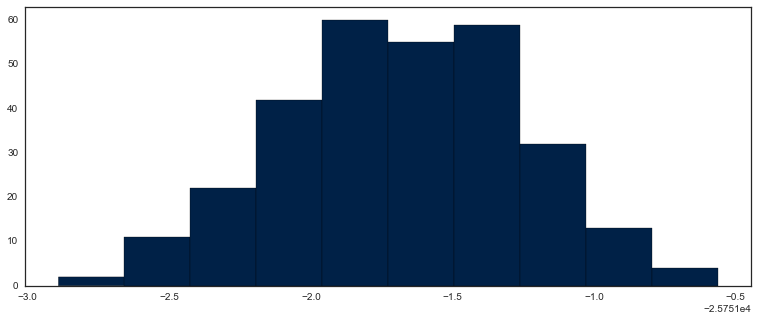

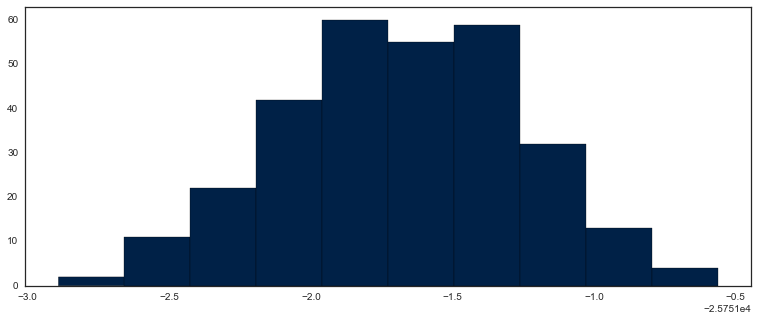

In [160]:
de.F = 0.25
de.C = 0.25
niter = 125
fig,ax = subplots(1,1)

try:
    for i,r in enumerate(de(niter)):
        if ((i+1)%10 == 0) or (i==niter-1):
            ax.cla()
            ax.hist(de._fitness)
            clear_output(wait=True)
            display(HTML('DE Iteration {:4d} max lnlike {:7.1f} med {:7.1f}'.format(i+1,-de.minimum_value,median(-de._fitness))))
            display(fig)
        if ((i+1)%5 == 0) and (i>120):
            for j in range(1):
                ipv = randint(0,high=de.n_pop)
                #pv = fmin(lambda pv: -lpf.lnposterior(pv), de.population[ipv], disp=True)
                #de._population[ipv,:] = pv
except KeyboardInterrupt:
    pass
finally:
    dfde = pd.DataFrame(de.population, columns=lpf.ps.names)
    dfde.to_hdf(result_file_c,'{:s}/de'.format(run_name))

In [115]:
def gpids(i):
    return [lpf.ibcn[i], lpf.ibe1[i], lpf.ibe2[i]] + lpf.iblr + [lpf.iwn[i]]
    
def modfun(pv, i):
    pids = gpids(i)
    pva = zeros(de.n_par)
    pva[pids] = pv
    bl = lpf.compute_baseline(pva)
    return bl[i]
        
def minfun(pv, i):
    m = ~lpf.otmasks[i]
    lnprior = sum([lpf.ps.priors[j].log(v) for j,v in zip(pids,pv)])
    lnlike  = ll_normal_es(lpf.fluxes[i][m], modfun(pv,i)[m], 0.001)
    return -(lnprior + lnlike)

In [121]:
pvbl = []
for i in range(1,2):
    pids = gpids(i)
    dem = DiffEvol(lambda pv:minfun(pv,i), lpf.ps.bounds[pids,:], 50)
    dem.optimize(400)
    pvbl.append(dem.population.copy())

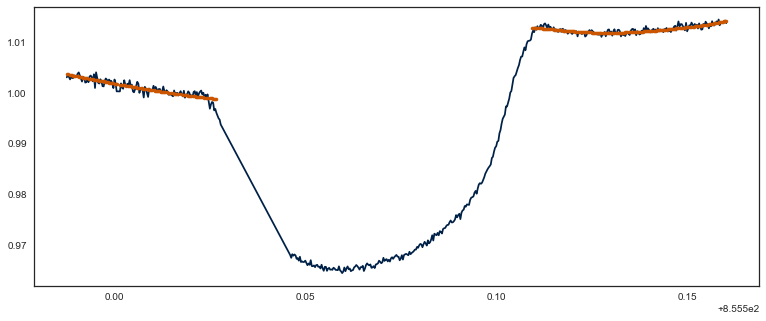

In [122]:
bl = modfun(dem.minimum_location, i)
m = ~lpf.otmasks[i]
plot(lpf.times[i], lpf.fluxes[i])
plot(lpf.times[i][m], bl[m], '.')

In [110]:
ipv = randint(0,high=de.n_pop)
#pva = fmin_powell(lambda pv: -lpf.lnposterior(pv), de.population[ipv], disp=True)
pva = fmin_powell(lambda pv: -lpf.lnposterior(pv), de.minimum_location, disp=True)

Optimization terminated successfully.
         Current function value: inf
         Iterations: 1
         Function evaluations: 692


In [112]:
ftr = lpf.compute_transit(pv)

In [164]:
fel = lpf.bl_elevation(pv)
fra = lpf.bl_rotang(pv)

In [174]:
de.population[:,lpf.ibe1[0]]

array([ 0.00058806,  0.00058114,  0.00059071,  0.00059143,  0.00058392,
        0.00058669,  0.00058866,  0.0005883 ,  0.00058799,  0.00058411,
        0.00058602,  0.00058318,  0.0005815 ,  0.00058661,  0.00058196,
        0.00057964,  0.00058434,  0.0005784 ,  0.00058522,  0.00058637,
        0.0005858 ,  0.00058961,  0.00058646,  0.0005877 ,  0.00059001,
        0.00058208,  0.00058749,  0.00059058,  0.00058119,  0.00058091,
        0.00058653,  0.00058483,  0.00059171,  0.00058659,  0.00058915,
        0.00058394,  0.0005802 ,  0.00058074,  0.00058459,  0.00058798,
        0.00058534,  0.0005832 ,  0.00058568,  0.00058181,  0.00058827,
        0.00058633,  0.00058406,  0.00058895,  0.00058729,  0.00058625,
        0.00058277,  0.00058334,  0.00058907,  0.00058212,  0.00057772,
        0.00058762,  0.00058564,  0.00058705,  0.00058646,  0.0005859 ,
        0.0005895 ,  0.00058316,  0.00059155,  0.00058487,  0.00058869,
        0.00057895,  0.00057845,  0.00057951,  0.00058374,  0.00

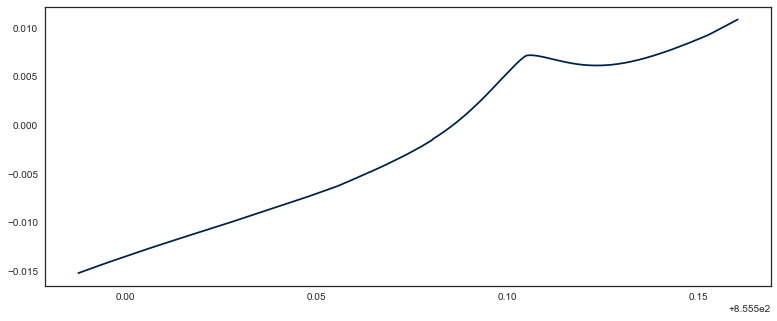

In [165]:
plot(lpf.times[0], fel[0]+fra[0])

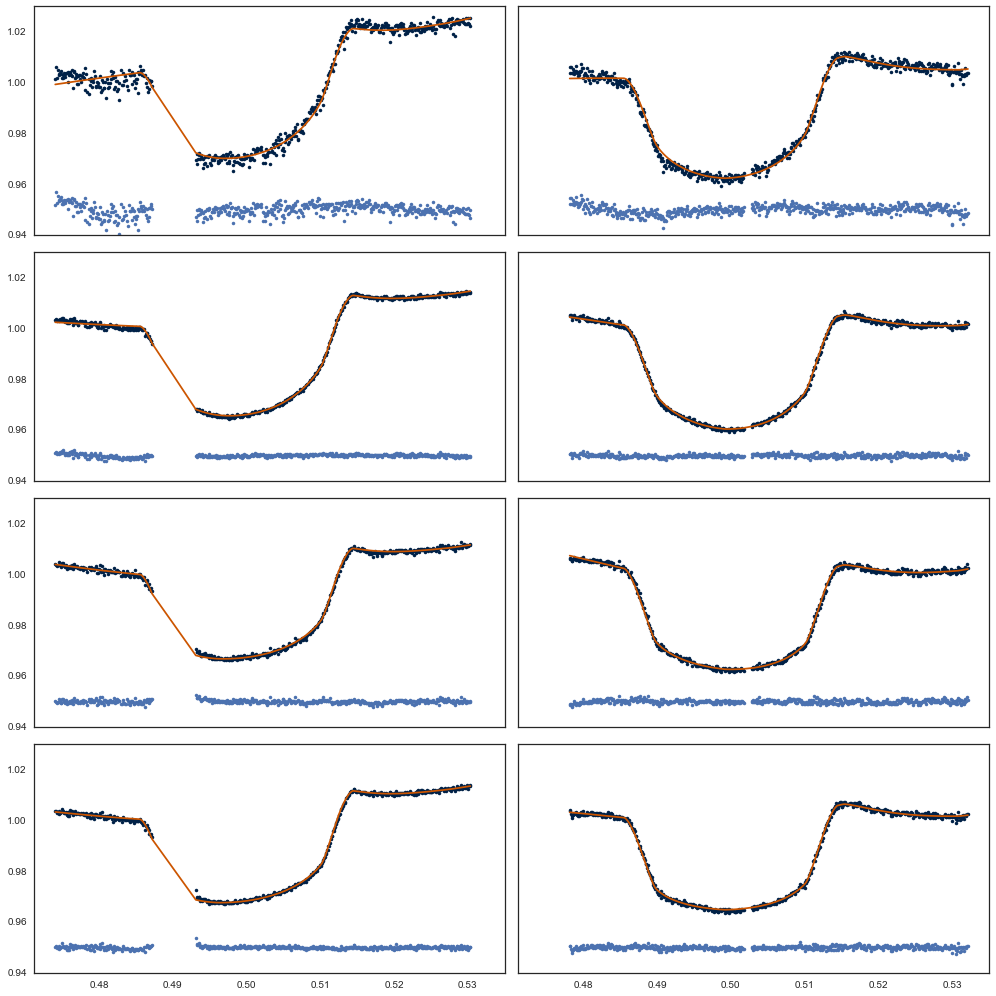

In [161]:
pv = de.minimum_location.copy()
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(4,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(4):
        ilc = 4*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[j,i].plot(phase, fos[ilc], '.')
        axs[j,i].plot(phase, fms[ilc])
        axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

In [175]:
sampler = EnsembleSampler(de.n_pop, de.n_par, lpf.lnposterior)

In [176]:
sampler.run_mcmc(de.population, 150);

In [185]:
sampler.run_mcmc(sampler.chain[:,-1,:], 10000);

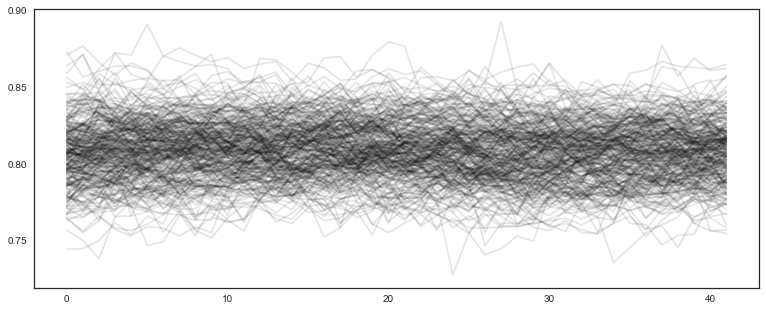

In [216]:
plot(sqrt(sampler.chain[:,6000::100,8].T), 'k', alpha=0.1);

In [195]:
fc = pd.read_hdf(join('..',result_file), 'vkrn_ldtk/fc')

In [220]:
dff = pd.DataFrame(sampler.chain[:,6200::100,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)

In [222]:
dff.to_hdf(result_file_c,'{:s}/fc'.format(run_name))

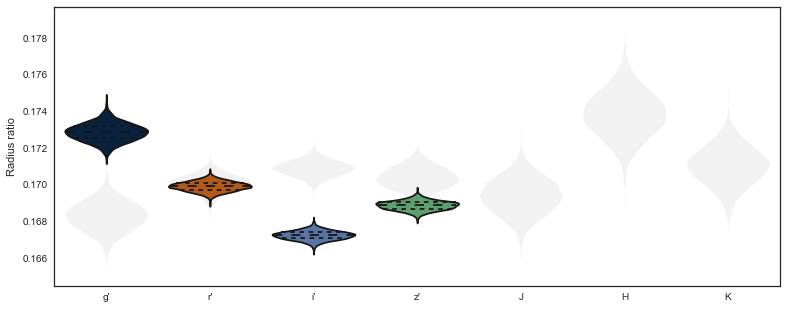

In [211]:
sb.violinplot(sqrt(fc['k2_g k2_r k2_i k2_z k2_J k2_H k2_K'.split()]), inner=None, color='0.95', linewidth=0, scale='width')
ax = sb.violinplot(sqrt(dff['k2_g k2_r k2_i k2_z'.split()]), inner='quartiles', scale='width')
setp(ax, xlim=(-0.5,6.5), xticks=arange(7), xticklabels="g' r' i' z' J H K".split(), ylabel='Radius ratio');

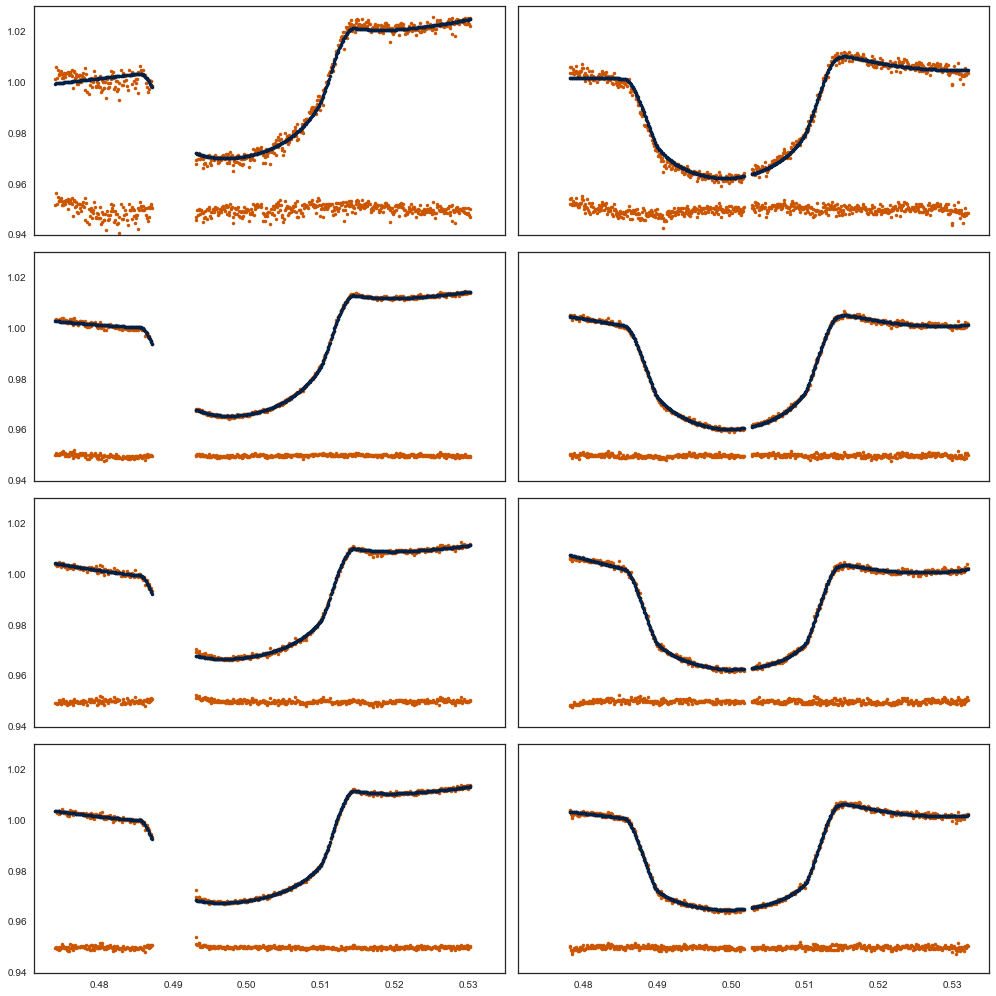

In [229]:
pv = median(dff.values, 0)
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(4,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(4):
        ilc = 4*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[j,i].plot(phase, fos[ilc], '.', c=cp[1])
        axs[j,i].plot(phase, fms[ilc], '.')
        axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()